## generator test

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath("../signals"))
sys.path.append(os.path.abspath("../data"))



## dataset test

Shape of X: (2, 150)
Shape of y: (2,)
Labels: [0 1]


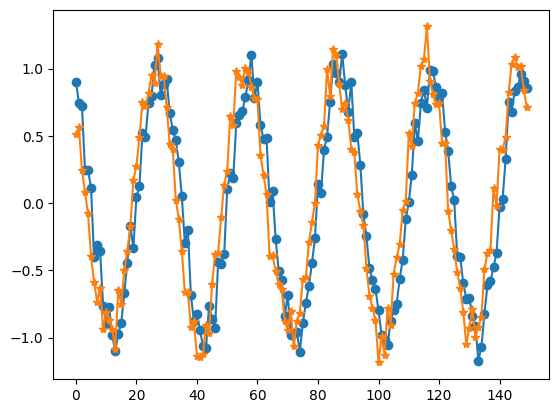

In [2]:
from dataset import create_labeled_dataset, get_kfold_splits


# Signal configuration: use sine signals with different freqs
class_configs = [
    (0, 'sine', {'args': [5, 0.1, 300, 5]}),
    (1, 'sine', {'args': [5.1, 0.1, 300, 5]}),
]

# Generate data
n_samples_per_class = 1
X, y = create_labeled_dataset(class_configs, n_samples_per_class, subsample_step=10, transient=0)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print("Labels:", np.unique(y))

plt.plot(X[0], 'o-')
plt.plot(X[1], '*-')
plt.show()

Shape of X: (2, 45)
Shape of y: (2,)
Labels: [0 1]


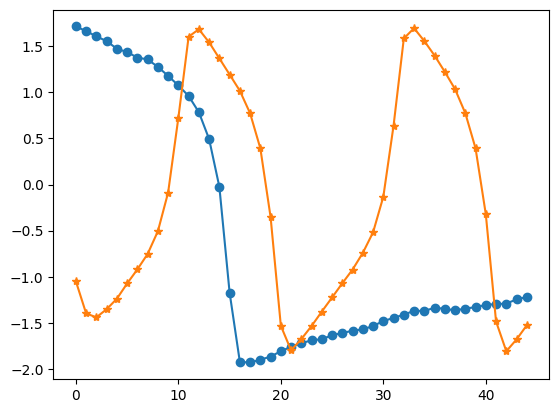

In [3]:
fhn_args = [0.8, 0.7, 0.08, 0.5, 0.02]  # [b0, b1, epsilon, I, noise_strength]
fhn_kwargs = {
    'length': 500,
    'dt': 0.1,
    'x0': [0, 0],
    'args': fhn_args
}

class_configs = [
    (0, 'fhn', {'length':500, 'dt': 0.1, 'x0': [0,0], 'args':[0.8, 0.7, 0.08, 0.5, 0.02]}),
    (1, 'fhn', {'length':500, 'dt': 0.1, 'x0': [0,0], 'args':[0.1, 1, 0.2, 0.0, 0.01]} ),
]

n_samples_per_class = 1
X, y = create_labeled_dataset(class_configs, n_samples_per_class, return_time = False, subsample_step=10, transient=50)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print("Labels:", np.unique(y))

plt.plot( X[0, :], 'o-')
plt.plot( X[1, :], '*-')
plt.show()

In [4]:
# After creating your dataset
X, y = create_labeled_dataset(class_configs, n_samples_per_class=10)

# Get K-Fold indices
splits = get_kfold_splits(X, y, n_splits=5)
splits_frames = []
# Loop through folds
for i, (train_idx, test_idx) in enumerate(splits):
    X_train = [X[j] for j in train_idx]
    X_test  = [X[j] for j in test_idx]
    y_train = [y[j] for j in train_idx]
    y_test  = [y[j] for j in test_idx]
    splits_frames.append((X_train, X_test, y_train, y_test))
    
    print(f"Fold {i + 1}:")
    print(f"  Train size: {len(X_train)}")
    print(f"  Test size:  {len(X_test)}")


Fold 1:
  Train size: 16
  Test size:  4
Fold 2:
  Train size: 16
  Test size:  4
Fold 3:
  Train size: 16
  Test size:  4
Fold 4:
  Train size: 16
  Test size:  4
Fold 5:
  Train size: 16
  Test size:  4


In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

for train_idx, test_idx in splits:
    X_train = [X[i] for i in train_idx]
    y_train = [y[i] for i in train_idx]
    X_test = [X[i] for i in test_idx]
    y_test = [y[i] for i in test_idx]
    
    # Flatten or preprocess if needed
    X_train_flat = [x.flatten() for x in X_train]
    X_test_flat = [x.flatten() for x in X_test]
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    clf = SVC()
    clf.fit(X_train_flat, y_train)
    y_pred = clf.predict(X_test_flat)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")

Accuracy: 1.00
Accuracy: 1.00
Accuracy: 1.00
Accuracy: 1.00
Accuracy: 1.00


## features test

Shape of extracted features: (16, 22)


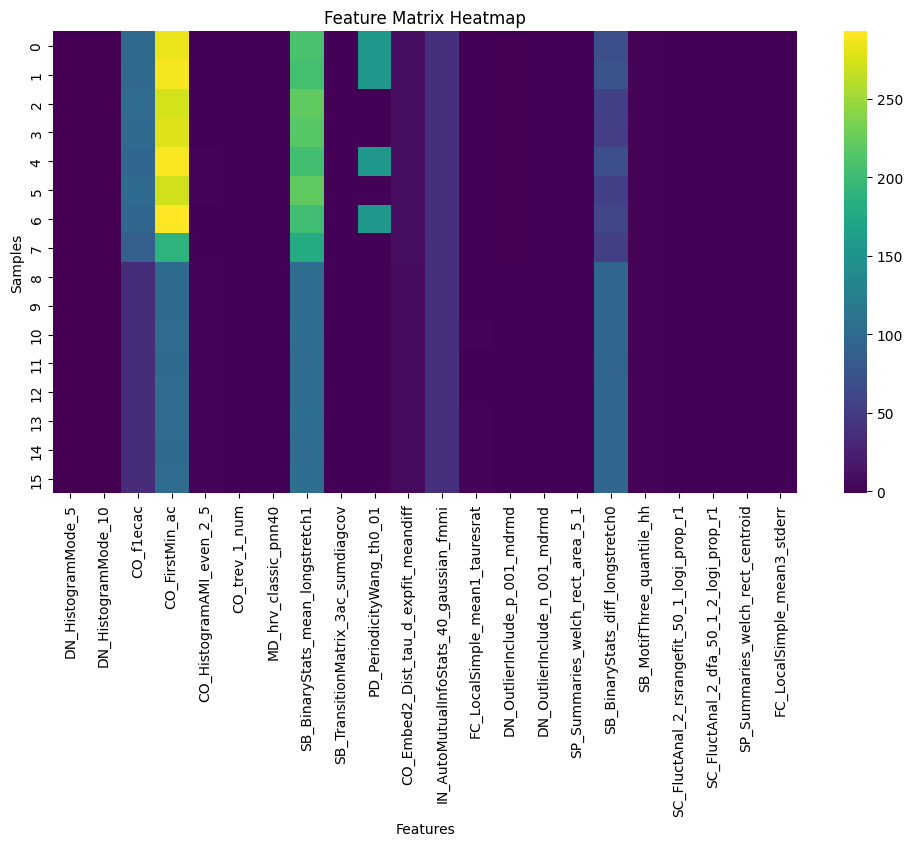

In [6]:
sys.path.append(os.path.abspath("../features"))
import seaborn as sns
from features import extract_features

# Extract features from raw time series
features = extract_features(X_train_flat)
print(f"Shape of extracted features: {features.shape}")

# Plot feature heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(features, cmap='viridis')
plt.title("Feature Matrix Heatmap")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()



In [8]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Set path and import
sys.path.append(os.path.abspath("../preprocessing"))
from preprocessing import apply_pca

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply PCA
X_pca, pca_model, scaler = apply_pca(X_scaled, n_components=2)

# Print explained variance
print("Explained variance ratio:", pca_model.explained_variance_ratio_)

Explained variance ratio: [0.85372808 0.08011021]


In [9]:
print("X shape (features):", features.shape)
print("y shape:", y_train.shape if hasattr(y_train, 'shape') else len(y_train))

X shape (features): (16, 22)
y shape: (16,)


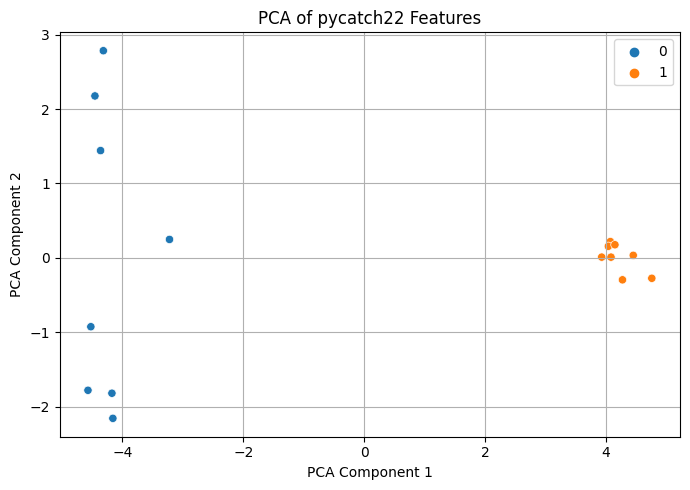

In [10]:
# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of pycatch22 Features")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
X_pca.shape

(16, 2)

## classification

In [12]:
sys.path.append(os.path.abspath("../models"))
from sklearn.svm import SVC

from classification import evaluate_model_auc, evaluate_single_fold

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# Example classifier
clf = SVC(probability=True)

# Run AUC evaluation
auc_scores = evaluate_model_auc(splits_frames, clf)

# Mean AUC
print("Mean AUC across folds:", np.mean(auc_scores))

Fold AUC: 1.000
Fold AUC: 1.000
Fold AUC: 1.000
Fold AUC: 1.000
Fold AUC: 1.000
Mean AUC across folds: 1.0


In [14]:
acc_scores = evaluate_model_auc(splits_frames, clf)
# Mean AUC
print("Mean AUC across folds:", np.mean(acc_scores))

Fold AUC: 1.000
Fold AUC: 1.000
Fold AUC: 1.000
Fold AUC: 1.000
Fold AUC: 1.000
Mean AUC across folds: 1.0


## all

In [16]:
# generating signals
class_configs = [
    (0, 'sine', {'args': [5, 0.1, 5, 3]}),
    (1, 'sine', {'args': [5.1, 0.1, 5, 3]}),
]
n_samples_per_class = 100
X, y = create_labeled_dataset(class_configs, n_samples_per_class, return_time=False)

In [17]:
# splits
splits = get_kfold_splits(X, y, n_splits=5)

splits_frames = []
# Loop through folds
for i, (train_idx, test_idx) in enumerate(splits):
    X_train = [X[j] for j in train_idx]
    X_test  = [X[j] for j in test_idx]
    y_train = [y[j] for j in train_idx]
    y_test  = [y[j] for j in test_idx]
    
    splits_frames.append((X_train, X_test, y_train, y_test))


In [21]:
auc_raw, auc_pca, auc_feat, auc_feat_pca = [], [], [], []

for i, (train_idx, test_idx) in enumerate(splits):
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # raw
    clf = SVC(probability=True)
    auc_raw.append(evaluate_single_fold(x_train, x_test, y_train, y_test, clf))

    # raw + pca
    clf = SVC(probability=True)
    x_train_pca, pca_model, scaler = apply_pca(x_train, n_components=2)
    x_test_pca = scaler.transform(x_test)
    x_test_pca = pca_model.transform(x_test_pca)
    auc_pca.append(evaluate_single_fold(x_train_pca, x_test_pca, y_train, y_test, clf))

    # features
    clf = SVC(probability=True)
    x_train_feat = extract_features(x_train)
    x_test_feat = extract_features(x_test)
    auc_feat.append(evaluate_single_fold(x_train_feat, x_test_feat, y_train, y_test, clf))

    # features + pca
    clf = SVC(probability=True)
    x_train_feat_pca, pca_model, scaler = apply_pca(x_train_feat, n_components=2)
    x_test_feat_pca = scaler.transform(x_test_feat)
    x_test_feat_pca = pca_model.transform(x_test_feat_pca)
    auc_feat_pca.append(evaluate_single_fold(x_train_feat_pca, x_test_feat_pca, y_train, y_test, clf))


/home/consuelo/Documentos/GitHub/TestCatch22/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/consuelo/Documentos/GitHub/TestCatch22/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/consuelo/Documentos/GitHub/TestCatch22/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/consuelo/Documentos/GitHub/TestCatch22/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/consuelo/Documentos/GitHub/TestCatch22/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature nam

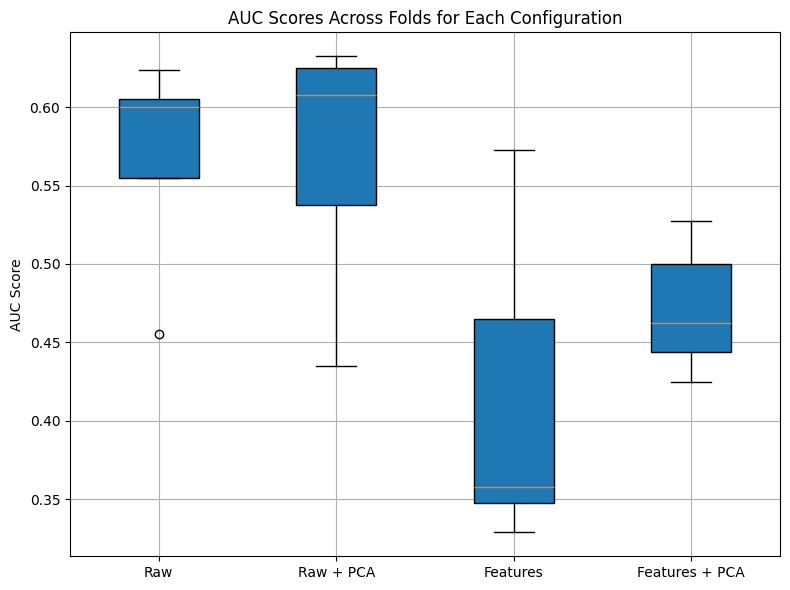

In [24]:
# Boxplot of AUCs
plt.figure(figsize=(8, 6))
plt.boxplot(
    [auc_raw, auc_pca, auc_feat, auc_feat_pca],
    labels=["Raw", "Raw + PCA", "Features", "Features + PCA"],
    patch_artist=True
)
plt.title("AUC Scores Across Folds for Each Configuration")
plt.ylabel("AUC Score")
plt.grid(True)
plt.tight_layout()
plt.show()